## 基于MindNLP在IAM手写数据集上微调TrOCR模型
在本笔记本中，我们将在 IAM 手写数据库（一组手写文本的注释图像）上微调预训练的 TrOCR 模型。

我们将使用新的 VisionEncoderDecoderModel 类来完成此任务，该类可用于将任何图像 Transformer 编码器（如 ViT、BEiT）与任何文本 Transformer 解码器（如 BERT、RoBERTa、GPT-2）组合。TrOCR 就是其中一个例子，因为它具有编码器-解码器架构，编码器的权重从预训练的 BEiT 初始化，解码器的权重从预训练的 RoBERTa 初始化。交叉注意层的权重是随机初始化的，之后作者在数百万张（部分合成的）手写文本注释图像上进一步预训练了该模型。

该图很好地概述了模型（来自原始论文）：
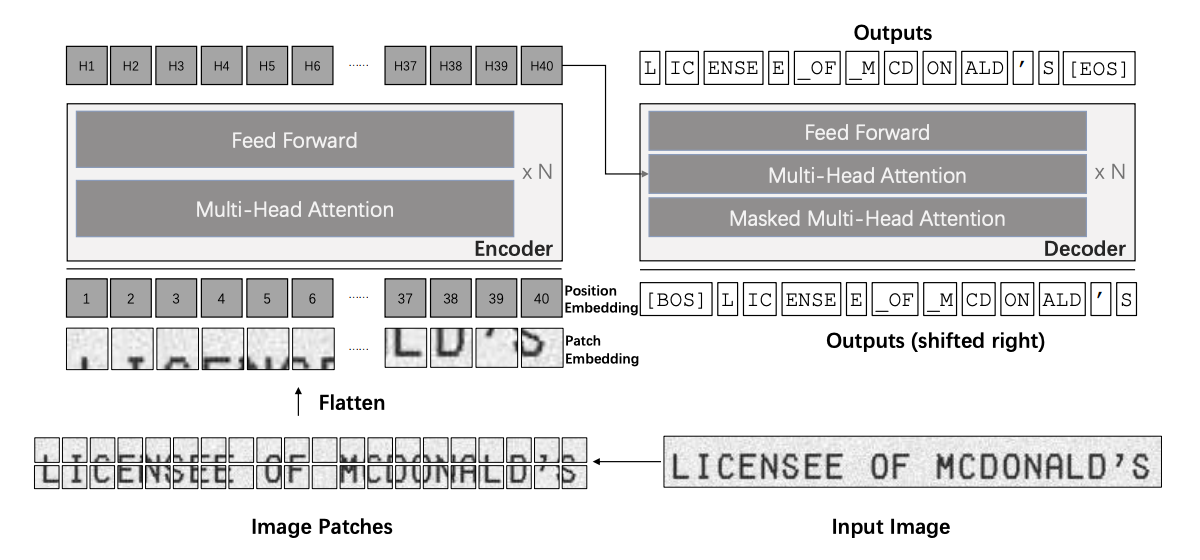
我们将使用原生 PyTorch 微调模型。

设置环境

首先，让我们安装所需的库：

MindNLP（用于 TrOCR 模型）
Datasets 和 Jiwer（用于评估指标）

In [ ]:
!pip install git+https://gitee.com/mindspore-lab/mindnlp.git
!pip install -q datasets jiwer

## 准备数据
我们首先下载数据。在这里，我只使用 IAM 测试集，因为这是 TrOCR 作者在 unilm 存储库中发布的。可以从这个页面下载。[https://github.com/microsoft/unilm/tree/master/trocr]

让我们创建一个常规的 PyTorch 数据集。我们首先创建一个包含 2 列的 Pandas 数据帧。每一行由图像的文件名和相应的文本组成。

In [1]:
import pandas as pd

df = pd.read_fwf('./IAM/gt_test.txt', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
del df[2]
# some file names end with jp instead of jpg, let's fix this
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df.head()

file_name                                               text
0  c04-110-00.jpg  Become a success with a disc and hey presto ! ...
1  c04-110-01.jpg  assuredness " Bella Bella Marie " ( Parlophone...
2  c04-110-02.jpg  I don't think he will storm the charts with th...
3  c04-110-03.jpg  CHRIS CHARLES , 39 , who lives in Stockton-on-...
4  c04-116-00.jpg  He is also a director of a couple of garages ....

我们使用 sklearn 的 train_test_split 函数将数据分成训练集和测试集

In [2]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

我们将使用 `TrOCRProcessor` 为模型准备数据。`TrOCRProcessor` 实际上只是 `ViTFeatureExtractor`（可用于调整大小和标准化图像）和 `RobertaTokenizer`（可用于将文本编码和解码为 `input_ids`）的包装器。

数据集的每个元素应返回两样东西：

* `pixel_values`，用作模型的输入。
* `labels`，是图像中相应文本的 `input_ids`。

In [3]:
import torch
from mindspore import Tensor
from mindspore.dataset import Dataset
from PIL import Image

class IAMDataset():
    def __init__(self, root_dir, df, processor, max_target_length=128):
        super(IAMDataset).__init__()
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + '/' + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="np").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        # encoding = {: , : }
        return Tensor(pixel_values.squeeze()), Tensor(labels)

In [4]:
from mindnlp.transformers.models.trocr import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='./IAM/image',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='./IAM/image',
                          df=test_df,
                          processor=processor)

C:\Users\virgo\.conda\envs\mindspore\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\virgo\AppData\Local\Temp\jieba.cache
Loading model cost 1.358 seconds.
Prefix dict has been built successfully.
100%|██████████| 224/224 [00:00<00:00, 224kB/s]
1.09kB [00:00, 1.07MB/s]                 
878kB [00:13, 66.4kB/s] 
446kB [00:00, 477kB/s] 
772B [00:00, 773kB/s]                    
C:\Users\virgo\Documents\GitHub\mindnlp\mindnlp\transformers\tokenization_utils_base.py:1526: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/trans

In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 2332
Number of validation examples: 583


让我们验证训练数据集中的一个例子

In [6]:
from mindspore.dataset import GeneratorDataset, BatchDataset

train_dataloader = GeneratorDataset(train_dataset, column_names=["pixel_values", "labels"], shuffle=True).batch(4)
eval_dataloader = GeneratorDataset(eval_dataset, column_names=["pixel_values", "labels"], shuffle=True)

In [7]:
for data in eval_dataloader.create_dict_iterator():
    print(data['pixel_values'].shape)
    break

(3, 384, 384)


我们还可以检查原始图像并解码标签：

In [8]:
image = Image.open(train_dataset.root_dir + '/' + train_df['file_name'][0]).convert("RGB")
image.show()
labels = train_dataset[0][1]
print(labels)
labels[labels == -100] = processor.tokenizer.pad_token_id
print(labels)
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

[    0  5632   957     8  3163  2156     5 11834 31520  3811  2156     2
  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100
  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100
  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100
  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100
  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100
  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100
  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100
  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100
  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100
  -100  -100  -100  -100  -100  -100  -100  -100]
[    0  5632   957     8  3163  2156     5 11834 31520  3811  2156     2
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
 

在这里，我们根据预训练权重初始化 TrOCR 模型。请注意，语言建模头的权重已从预训练中初始化，因为模型已在预训练阶段训练为生成文本。有关详细信息，请参阅论文。

In [9]:
from mindnlp.transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
print(model)

Some weights of the model checkpoint at microsoft/trocr-base-stage1 were not used when initializing VisionEncoderDecoderModel: ['decoder.model.decoder.embed_positions._float_tensor']
- This IS expected if you are initializing VisionEncoderDecoderModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VisionEncoderDecoderModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


我们需要设置几个属性，即：
- 从标签创建decoder_input_ids所需的属性（模型将通过将标签向右移动一个位置并在前面添加decoder_start_token_id，以及用pad_token_id替换-）
- 模型的词汇量（用于解码器顶部的语言建模头）
- 生成文本时使用的波束搜索相关参数。

In [10]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [11]:
from mindnlp import evaluate

cer_metric = evaluate.load("cer")

In [12]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [13]:
from mindnlp.core.optim import AdamW
from tqdm import tqdm
import mindspore

optimizer = AdamW(model.parameters(), lr=5e-5)
for epoch in range(1):
    # train
    model.set_train()
    train_loss = 0.0
    for bacth in tqdm(train_dataloader.create_dict_iterator()):
        pixel_values = bacth['pixel_values']
        labels = bacth['labels']
        weights = ()
        for group in optimizer.param_groups:
            weights += tuple(group['params'])


        def compute_loss(pixel_values, labels):
            output = model(pixel_values=pixel_values, labels=labels)
            loss = output.loss
            return loss


        grad_fn = mindspore.value_and_grad(compute_loss, None, weights)

        loss, grads = grad_fn(pixel_values, labels)
        optimizer.step(grads)


6it [08:26, 84.34s/it]


KeyboardInterrupt: 